In [1]:
import pandas as pd
import numpy as np
import gc
%matplotlib inline 
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [2]:
def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

In [3]:
## load data
item_categories = pd.read_csv('data/item_categories.csv')
items = pd.read_csv('data/items.csv')
shops = pd.read_csv('data/shops.csv')
sales_train = pd.read_csv('data/sales_train.csv')

In [4]:
test = pd.read_csv('data/test.csv')
test.shape

(214200, 3)

In [5]:
test_train= pd.DataFrame(columns=['shop_id', 'item_id', 'date_block_num', 'item_price']) #'max_price', 'min_price', 'avg_price'])
for block_num in np.sort(sales_train.date_block_num.unique())[::-1]:
    test_dummy = test.merge(sales_train[sales_train.date_block_num == block_num], on=['shop_id', 'item_id'])
    test_dummy = test_dummy.groupby(['shop_id', 'item_id', 'date_block_num'], as_index=False).agg({'item_price' : 'mean'})#{'max_price':'max', 'min_price':'min', 'avg_price': 'mean'}})
#     test_dummy.columns = [col[0] if col[-1]=='' else col[-1] for col in test_dummy.columns.values]
#     test_dummy.head(10)
    test_train =pd.concat([test_train,test_dummy], axis=0)
test_train = test_train.merge(test_train.groupby(['shop_id', 'item_id'], as_index= False).agg({'date_block_num': np.max}), on=['shop_id', 'item_id', 'date_block_num'])

del test_dummy
gc.collect();
test_train.shape

(111404, 4)

In [6]:
test_train = pd.merge(test, test_train, how='left', on=['shop_id', 'item_id'])
test_train.date_block_num = 34
test_train = test_train.fillna(0)
test_train.head()

,ID,shop_id,item_id,date_block_num,item_price
0,0,5,5037,34,749.5
1,1,5,5320,34,0.0
2,2,5,5233,34,1199.0
3,3,5,5232,34,599.0
4,4,5,5268,34,0.0


In [7]:
from itertools import product
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}}) #, 'item_price' : {'max_price':'max', 'min_price':'min', 'avg_price': 'mean'}})

#fix column names
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
all_data = pd.concat([all_data, test_train.drop('ID', axis=1)], axis=0)

# # Groupby data to get shop-item-month aggregates
# gb = sales_train.groupby(index_cols,as_index=False).agg({'item_cnt_day':{'target':'sum'}})
# # Fix column names
# gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values] 
# # Join it to the grid
# all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)

# Same as above but with shop-month aggregates
gb = sales_train.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_shop':'sum'}})
gb.columns = [col[0] if col[-1]=='' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Same as above but with item-month aggregates
gb = sales_train.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':{'target_item':'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

## create future using item category
all_data = all_data.merge(items[['item_id','item_category_id']], how='left', on = ['item_id'])
sales_train_dummy = sales_train.merge(items, how='left', on=['item_id'])
gb = sales_train_dummy.groupby(['item_category_id', 'date_block_num'], as_index=False).agg({'item_cnt_day': {'target_item_category' : 'sum'}})
gb.columns = [col[0] if col[-1] == '' else col[-1] for col in gb.columns.values]
all_data = pd.merge(all_data, gb, how='left', on=['item_category_id', 'date_block_num']).fillna(0)

# Downcast dtypes from 64 to 32 bit to save memory
all_data = downcast_dtypes(all_data)
del grid, gb, sales_train_dummy
gc.collect();

/Users/arjasethan/anaconda/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [8]:
all_data[all_data.date_block_num == 34].head(10)

,date_block_num,item_id,item_price,shop_id,target,target_shop,target_item,item_category_id,target_item_category
10913850,34,5037,749.5,5,0.0,0.0,0.0,19,0.0
10913851,34,5320,0.0,5,0.0,0.0,0.0,55,0.0
10913852,34,5233,1199.0,5,0.0,0.0,0.0,19,0.0
10913853,34,5232,599.0,5,0.0,0.0,0.0,23,0.0
10913854,34,5268,0.0,5,0.0,0.0,0.0,20,0.0
10913855,34,5039,1499.0,5,0.0,0.0,0.0,23,0.0
10913856,34,5041,3999.0,5,0.0,0.0,0.0,20,0.0
10913857,34,5046,349.0,5,0.0,0.0,0.0,55,0.0
10913858,34,5319,299.0,5,0.0,0.0,0.0,55,0.0
10913859,34,5003,0.0,5,0.0,0.0,0.0,20,0.0


In [9]:
# List of columns that we will use to create lags
index_cols.append('item_category_id')
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Don't use old data from year 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# List of all lagged features
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# We will drop these at fitting stage
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Category for each item
# item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

# all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

In [10]:
all_data[all_data.date_block_num ==34].head(10)

,date_block_num,item_id,item_price,shop_id,target,target_shop,target_item,item_category_id,target_item_category,item_price_lag_1,...,item_price_lag_5,target_lag_5,target_item_lag_5,target_item_category_lag_5,target_shop_lag_5,item_price_lag_12,target_lag_12,target_item_lag_12,target_item_category_lag_12,target_shop_lag_12
10913850,34,5037,749.5,5,0.0,0.0,0.0,19,0.0,0.0,...,0.0,1.0,105.0,3487.0,954.0,0.0,1.0,65.0,6134.0,1445.0
10913851,34,5320,0.0,5,0.0,0.0,0.0,55,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10913852,34,5233,1199.0,5,0.0,0.0,0.0,19,0.0,0.0,...,0.0,2.0,119.0,3487.0,954.0,0.0,0.0,0.0,0.0,0.0
10913853,34,5232,599.0,5,0.0,0.0,0.0,23,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10913854,34,5268,0.0,5,0.0,0.0,0.0,20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10913855,34,5039,1499.0,5,0.0,0.0,0.0,23,0.0,0.0,...,0.0,0.0,84.0,2984.0,954.0,0.0,0.0,45.0,5275.0,1445.0
10913856,34,5041,3999.0,5,0.0,0.0,0.0,20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10913857,34,5046,349.0,5,0.0,0.0,0.0,55,0.0,0.0,...,0.0,1.0,21.0,6017.0,954.0,0.0,1.0,29.0,9809.0,1445.0
10913858,34,5319,299.0,5,0.0,0.0,0.0,55,0.0,0.0,...,0.0,4.0,56.0,6017.0,954.0,0.0,5.0,270.0,9809.0,1445.0
10913859,34,5003,0.0,5,0.0,0.0,0.0,20,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()
val_block = dates.max() -1
print('Test `date_block_num` is %d' % last_block)
print('Val `date_block_num` is %d' % val_block)

Test `date_block_num` is 34
Val `date_block_num` is 33


In [12]:
dates_train = dates[dates < val_block]
dates_val = dates[dates == val_block]
dates_test = dates[dates == last_block]

X_train = all_data.loc[dates <  val_block]
X_val = all_data.loc[dates == val_block]
X_test =  all_data.loc[dates == last_block]

y_train = all_data.loc[dates <  val_block, 'target'].values
y_val =  all_data.loc[dates == val_block, 'target'].values

In [13]:
lr = LinearRegression()
lr.fit(X_train.drop(to_drop_cols, axis=1).values, y_train)
pred_lr = lr.predict(X_val.drop(to_drop_cols, axis=1).values)

print('Train R-squared for linreg is %f' % r2_score(y_train, lr.predict(X_train.drop(to_drop_cols, axis=1).values)))
print('Train R-squared for linreg is %f' % r2_score(y_val, pred_lr))

Train R-squared for linreg is 0.470225
Train R-squared for linreg is 0.255082


In [14]:
def prepare_submit(pred_data, path):
    submit = pd.merge(test, pred_data, on=['shop_id', 'item_id'], how='left')[["ID", "item_cnt_month"]]
    submit['item_cnt_month'] = submit.item_cnt_month.fillna(0).clip(0,20)
    submit.to_csv(path, sep=",", index=False)

In [15]:
#uncomment for submission(lb score : 1.07770)
# test_lr_without_encoding = X_test.copy()
# test_lr_without_encoding['item_cnt_month'] = lr.predict(test_lr_without_encoding.drop(to_drop_cols, axis=1).values)
# prepare_submit(test_lr_without_encoding, path='data/lr_without_encoding1.csv')

In [16]:
#mean encoding

# item_id encoding
from sklearn.model_selection import KFold
target = X_train.target.values
kf = KFold(n_splits = 5, shuffle = False)
X_train['item_target_enc'] = np.nan
for tr_inds, val_inds in kf.split(target):
    tr_fold, val_fold = X_train.iloc[tr_inds], X_train.iloc[val_inds]
    val_fold['item_target_enc'] = val_fold['item_id'].map(tr_fold.groupby('item_id').target.mean())
    X_train.iloc[val_inds, :] = val_fold

global_mean = X_train.target.mean()
X_train.fillna(global_mean, inplace= True)

#shopid_id encoding
X_train['shop_target_enc'] = np.nan
for tr_inds, val_inds in kf.split(target):
    tr_fold, val_fold = X_train.iloc[tr_inds], X_train.iloc[val_inds]
    val_fold['shop_target_enc'] = val_fold['shop_id'].map(tr_fold.groupby('shop_id').target.mean())
    X_train.iloc[val_inds, :] = val_fold

global_mean = X_train.target.mean()
X_train.fillna(global_mean, inplace= True)

# caategory_id encoding
X_train['category_target_enc'] = np.nan
for tr_inds, val_inds in kf.split(target):
    tr_fold, val_fold = X_train.iloc[tr_inds], X_train.iloc[val_inds]
    val_fold['category_target_enc'] = val_fold['item_category_id'].map(tr_fold.groupby('item_category_id').target.mean())
    X_train.iloc[val_inds, :] = val_fold

global_mean = X_train.target.mean()
X_train.fillna(global_mean, inplace= True)

/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/arjasethan/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [17]:
## downcast data type
X_train = downcast_dtypes(X_train)
X_train.head(10)

/Users/arjasethan/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,date_block_num,item_id,item_price,shop_id,target,target_shop,target_item,item_category_id,target_item_category,item_price_lag_1,...,target_item_category_lag_5,target_shop_lag_5,item_price_lag_12,target_lag_12,target_item_lag_12,target_item_category_lag_12,target_shop_lag_12,item_target_enc,shop_target_enc,category_target_enc
4488756,12,27,0.0,2,0.0,890.0,1.0,19,9282.0,0.0,...,10488.0,875.0,0.0,1.0,7.0,8983.0,1146.0,0.040816,0.161184,0.585405
4488757,12,30,0.0,2,0.0,890.0,58.0,40,22065.0,0.0,...,24130.0,875.0,0.0,0.0,0.0,0.0,0.0,0.205596,0.161184,0.242273
4488758,12,31,0.0,2,0.0,890.0,15.0,37,7511.0,0.0,...,8680.0,875.0,0.0,0.0,0.0,0.0,0.0,0.324818,0.161184,0.159289
4488759,12,32,0.0,2,1.0,890.0,84.0,40,22065.0,0.0,...,24130.0,875.0,0.0,0.0,299.0,33489.0,1146.0,0.603406,0.161184,0.242273
4488760,12,33,0.0,2,1.0,890.0,42.0,37,7511.0,0.0,...,8680.0,875.0,0.0,1.0,61.0,6094.0,1146.0,0.350365,0.161184,0.159289
4488761,12,34,0.0,2,0.0,890.0,6.0,40,22065.0,0.0,...,24130.0,875.0,0.0,0.0,9.0,33489.0,1146.0,0.033784,0.161184,0.242273
4488762,12,36,0.0,2,0.0,890.0,2.0,37,7511.0,0.0,...,8680.0,875.0,0.0,0.0,0.0,0.0,0.0,0.031311,0.161184,0.159289
4488763,12,37,0.0,2,0.0,890.0,5.0,40,22065.0,0.0,...,24130.0,875.0,0.0,0.0,0.0,0.0,0.0,0.053459,0.161184,0.242273
4488764,12,39,0.0,2,0.0,890.0,1.0,41,1257.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022472,0.161184,0.141051
4488765,12,40,0.0,2,0.0,890.0,2.0,57,984.0,0.0,...,1316.0,875.0,0.0,0.0,4.0,1539.0,1146.0,0.037433,0.161184,0.093589


In [18]:
#mean encoding for test data
X_val['item_target_enc'] = X_val['item_id'].map(X_train.groupby('item_id').target.mean())
X_val['shop_target_enc'] = X_val['shop_id'].map(X_train.groupby('shop_id').target.mean())
X_val['category_target_enc'] = X_val['item_category_id'].map(X_train.groupby('item_category_id').target.mean())
X_val.fillna(global_mean, inplace=True)
X_val = downcast_dtypes(X_val)

/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [19]:
## dropping unnessesary columns
X_train = X_train.drop( to_drop_cols + ['shop_id', 'item_id', 'item_category_id'], axis=1)
X_val = X_val.drop(to_drop_cols + ['shop_id', 'item_id', 'item_category_id'], axis=1)

In [20]:
print('Train data shape: ',X_train.shape)
print('Test data shape: ',X_val.shape)

Train data shape:  (6186922, 33)
Test data shape:  (238172, 33)


In [21]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_val.values)

print('Train R-squared for linreg is %f' % r2_score(y_train, lr.predict(X_train.values)))
print('Val R-squared for linreg is %f' % r2_score(y_val, pred_lr))

Train R-squared for linreg is 0.474260
Val R-squared for linreg is 0.257853


In [22]:
## mean encoding for test data
X_test['item_target_enc'] = X_test['item_id'].map(all_data[all_data.date_block_num < last_block].groupby('item_id').target.mean())
X_test['shop_target_enc'] = X_test['shop_id'].map(all_data[all_data.date_block_num < last_block].groupby('shop_id').target.mean())
X_test['category_target_enc'] = X_test['item_category_id'].map(all_data[all_data.date_block_num < last_block].groupby('item_category_id').target.mean())
X_test.fillna(global_mean, inplace=True)
X_test = downcast_dtypes(X_test)

/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/arjasethan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [31]:
# lb score : 1.06419
# lr_with_encoding = X_test.copy()
# lr_with_encoding['item_cnt_month'] = lr.predict(X_test.drop( to_drop_cols + ['shop_id', 'item_id', 'item_category_id'], axis=1).values)
# prepare_submit(lr_with_encoding, path='data/lr_with_encoding1.csv')

In [23]:
import lightgbm as lgb

In [31]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':4, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.015, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 200)
pred_lgb = model.predict(X_val)

print('Train R-squared for LightGBM is %f' % r2_score(y_train, model.predict(X_train)))
print('Val R-squared for LightGBM is %f' % r2_score(y_val, pred_lgb))

Train R-squared for LightGBM is 0.516967
Val R-squared for LightGBM is 0.210647


In [33]:
seed = 123
np.random.seed(seed)

import tensorflow as tf
import keras, keras.layers as L, keras.backend as K


In [104]:
def neural_net(input_shape, hidden_layers, nodes_per_layer, activation = 'relu'):
    model = keras.models.Sequential()
    model.add(L.InputLayer(input_shape=(input_shape,)))
    for i in range(hidden_layers):
        model.add(L.Dense(nodes_per_layer, activation= activation, kernel_regularizer= keras.regularizers.l2(0.01)))
    model.add(L.Dense(1, activation='relu'))
    return model

In [61]:
nn1hidden_layer = neural_net(X_train.shape[1], hidden_layers=1, nodes_per_layer=100)
nn1hidden_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 33)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               3400      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 3,501
Trainable params: 3,501
Non-trainable params: 0
_________________________________________________________________


In [62]:
sgd = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
nn1hidden_layer.compile(loss='mean_squared_error', optimizer=sgd)
nn1hidden_layer.fit(x=X_train, y=y_train, batch_size=500, validation_data=(X_val, y_val), epochs=5)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/5
6186922/6186922 [==============================] - 27s 4us/step - loss: 184.7815 - val_loss: 28.6339
Epoch 2/5
6186922/6186922 [==============================] - 27s 4us/step - loss: 12.5787 - val_loss: 28.6339
Epoch 3/5
6186922/6186922 [==============================] - 27s 4us/step - loss: 12.5787 - val_loss: 28.6339
Epoch 4/5
6186922/6186922 [==============================] - 27s 4us/step - loss: 12.5787 - val_loss: 28.6339
Epoch 5/5
6186922/6186922 [==============================] - 27s 4us/step - loss: 12.5787 - val_loss: 28.6339


In [63]:
nn1hidden_pred = nn1hidden_layer.predict(X_val)
print('Train R-squared for LightGBM is %f' % r2_score(y_train, nn1hidden_layer.predict(X_train)))
print('Val R-squared for LightGBM is %f' % r2_score(y_val, nn1hidden_pred))

Train R-squared for LightGBM is -0.008499
Val R-squared for LightGBM is -0.003118


In [151]:
nn3hidden_layer = neural_net(X_train.shape[1], hidden_layers=10, nodes_per_layer=200, activation='tanh')
nn3hidden_layer.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 33)                0         
_________________________________________________________________
dense_108 (Dense)            (None, 200)               6800      
_________________________________________________________________
dense_109 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_110 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_111 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_112 (Dense)            (None, 200)               40200     
_________________________________________________________________
dense_113 (Dense)            (None, 200)               40200     
__________

In [152]:
sgd1 = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
nn3hidden_layer.compile(loss='mean_squared_error', optimizer=sgd1)
nn3hidden_layer.fit(x=X_train, y=y_train, batch_size=2000, validation_data=(X_val, y_val), epochs=5)

Train on 6186922 samples, validate on 238172 samples
Epoch 1/5
6186922/6186922 [==============================] - 228s 37us/step - loss: 14.0680 - val_loss: 28.9193
Epoch 2/5
6186922/6186922 [==============================] - 215s 35us/step - loss: 14.0090 - val_loss: 29.3319
Epoch 3/5
6186922/6186922 [==============================] - 212s 34us/step - loss: 12.6342 - val_loss: 28.6339
Epoch 4/5
6186922/6186922 [==============================] - 213s 35us/step - loss: 12.5787 - val_loss: 28.6339
Epoch 5/5
6186922/6186922 [==============================] - 214s 35us/step - loss: 12.5787 - val_loss: 28.6339


In [103]:
nn3hidden_pred = np.array(nn3hidden_layer.predict(X_val))
print('Train R-squared for 3 layer network is %f' % r2_score(y_train, nn3hidden_layer.predict(X_train)))
print('Val R-squared for 3 layer network is %f' % r2_score(y_val, nn3hidden_pred))

Train R-squared for 3 layer network is 0.009177
Val R-squared for 3 layer network is -0.007262


In [113]:
from sklearn.ensemble import RandomForestRegressor

In [164]:
rf = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_depth=5, max_features='auto')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_val)

print('Train R-squared for random forest is %f' % r2_score(y_train, rf.predict(X_train)))
print('Val R-squared for random forest is %f' % r2_score(y_val, rf_pred))

Train R-squared for random forest is 0.578129
Val R-squared for random forest is 0.240380


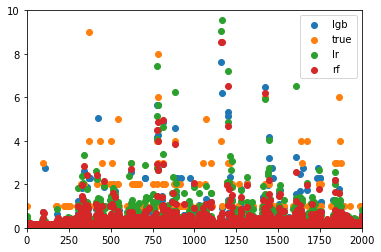

In [148]:
x = list(range(len(y_val)))
plt.scatter( x, pred_lgb)
plt.scatter( x, y_val)
plt.scatter( x, pred_lr)
plt.scatter( x, rf_pred)
plt.legend(['lgb', 'true', 'lr', 'rf'])
plt.ylim(0,10)
plt.xlim(0,2000)
plt.show()

In [194]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# That is how we get target for the 2nd level dataset
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [196]:
X_train_level2 = np.zeros([y_train_level2.shape[0], 3])


# Now fill `X_train_level2` with metafeatures
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Split `X_train` into parts
           Remember, that corresponding dates are stored in `dates_train` 
        2. Fit linear regression 
        3. Fit LightGBM and put predictions          
        4. Store predictions from 2. and 3. in the right place of `X_train_level2`. 
           You can use `dates_train_level2` for it
           Make sure the order of the meta-features is the same as in `X_test_level2`
    '''      
    
    #  YOUR CODE GOES HERE
    X_train_block = X_train[dates_train < cur_block_num]
    y_train_block = y_train[dates_train < cur_block_num]
    lr_block = LinearRegression()
    lr_block.fit(X_train_block, y_train_block)
    lgb_block = lgb.train(lgb_params, lgb.Dataset(X_train_block, label=y_train_block), 100)
    rf_block = RandomForestRegressor(n_estimators=150, n_jobs=-1, max_depth=5, max_features='auto')
    rf_block.fit(X_train_block, y_train_block)
    X_train_level2[dates_train_level2 == cur_block_num, 0] = lr_block.predict(X_train[dates_train == cur_block_num])
    X_train_level2[dates_train_level2 == cur_block_num, 1] = lgb_block.predict(X_train[dates_train == cur_block_num])
    X_train_level2[dates_train_level2 == cur_block_num, 2] = rf_block.predict(X_train[dates_train == cur_block_num])



27
28
29
30
31
32


In [201]:
stacking_lr = LinearRegression()
stacking_lr.fit(X_train_level2, y_train_level2)
y_val_level2 = np.zeros([pred_lr.shape[0], 3])
y_val_level2[:, 0] = pred_lr
y_val_level2[:, 1] = pred_lgb
y_val_level2[:, 2] = rf_pred
pred_stacking = stacking_lr.predict(y_val_level2)

print('Train R-squared for stacking is %f' % r2_score(y_train_level2, stacking_lr.predict(X_train_level2)))
print('Val R-squared for stacking is %f' % r2_score(y_val, rf_pred))

Train R-squared for stacking is 0.270311
Val R-squared for stacking is 0.240380
